In [1]:
import pandas as pd
import numpy as np
import spacy, nltk, gensim
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from ast import literal_eval

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davitmartirosyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/davitmartirosyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/davitmartirosyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davitmartirosyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# reading the data
data_recipe = pd.read_json('data/full_format_recipes.json')

In [3]:
data_recipe.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [4]:
data_recipe.shape

(20130, 11)

In [5]:
data_recipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 11 columns):
directions     20111 non-null object
fat            15908 non-null float64
date           20111 non-null datetime64[ns, UTC]
categories     20111 non-null object
calories       15976 non-null float64
desc           13495 non-null object
protein        15929 non-null float64
rating         20100 non-null float64
title          20111 non-null object
ingredients    20111 non-null object
sodium         15974 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.7+ MB


In [6]:
# let's drop the column 'desc', since we are not going to use that
data_recipe = data_recipe.drop('desc',axis=1)

In [7]:
data_recipe.isnull().sum()

directions       19
fat            4222
date             19
categories       19
calories       4154
protein        4201
rating           30
title            19
ingredients      19
sodium         4156
dtype: int64

In [8]:
# let's drop all rows with at least one missing value
data_recipe = data_recipe.dropna()

In [9]:
data_recipe.shape

(15896, 10)

In [10]:
data_recipe.loc[0]['ingredients']

['4 cups low-sodium vegetable or chicken stock',
 '1 cup dried brown lentils',
 '1/2 cup dried French green lentils',
 '2 stalks celery, chopped',
 '1 large carrot, peeled and chopped',
 '1 sprig fresh thyme',
 '1 teaspoon kosher salt',
 '1 medium tomato, cored, seeded, and diced',
 '1 small Fuji apple, cored and diced',
 '1 tablespoon freshly squeezed lemon juice',
 '2 teaspoons extra-virgin olive oil',
 'Freshly ground black pepper to taste',
 '3 sheets whole-wheat lavash, cut in half crosswise, or 6 (12-inch) flour tortillas',
 '3/4 pound turkey breast, thinly sliced',
 '1/2 head Bibb lettuce']

In [11]:
data_recipe.loc[1]['ingredients']

['1 1/2 cups whipping cream',
 '2 medium onions, chopped',
 '5 teaspoons salt',
 '3 bay leaves',
 '3 whole cloves',
 '1 large garlic clove, crushed',
 '1 teaspoon pepper',
 '1/8 teaspoon ground nutmeg',
 'Pinch of dried thyme, crumbled',
 '8 large shallots, minced',
 '1 tablespoon butter',
 '1 pound trimmed boneless center pork loin, sinew removed cut into 1-inch chunks, well chilled',
 '3 eggs',
 '6 tablespoon all purpose flour',
 '1/4 cup tawny Port',
 '3 tablespoons dried currants, minced',
 'Lettuce leaves',
 'Cracked peppercorns',
 'Minced fresh parsley',
 'Bay leaves',
 'French bread baguette slices',
 '3 tablespoons olive oil',
 '2 large red onions, halved, sliced',
 '3 tablespoons dried currants',
 '3 tablespoons red wine vinegar',
 '1 tablespoons canned chicken broth',
 '2 teaspoons chopped fresh thyme or 3/4 teaspoon dried, crumbled',
 '1/2 teaspoon sugar']

In [12]:
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: ' '.join(x))

In [13]:
data_recipe.head(5)

,directions,fat,date,categories,calories,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,30.0,2.500,"Lentil, Apple, and Turkey Wrap",4 cups low-sodium vegetable or chicken stock 1...,559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"1 1/2 cups whipping cream 2 medium onions, cho...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,6.0,3.750,Potato and Fennel Soup Hodge,"1 fennel bulb (sometimes called anise), stalks...",165.0
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,20.0,3.125,Spinach Noodle Casserole,"1 12-ounce package frozen spinach soufflé, tha...",452.0
5,"[Mix basil, mayonnaise and butter in processor...",79.0,2004-08-20 04:00:00+00:00,"[Sandwich, Food Processor, Tomato, Kid-Friendl...",948.0,19.0,4.375,The Best Blts,2 1/2 cups (lightly packed) fresh basil leaves...,1042.0


In [14]:
data_recipe.loc[0]['ingredients']

'4 cups low-sodium vegetable or chicken stock 1 cup dried brown lentils 1/2 cup dried French green lentils 2 stalks celery, chopped 1 large carrot, peeled and chopped 1 sprig fresh thyme 1 teaspoon kosher salt 1 medium tomato, cored, seeded, and diced 1 small Fuji apple, cored and diced 1 tablespoon freshly squeezed lemon juice 2 teaspoons extra-virgin olive oil Freshly ground black pepper to taste 3 sheets whole-wheat lavash, cut in half crosswise, or 6 (12-inch) flour tortillas 3/4 pound turkey breast, thinly sliced 1/2 head Bibb lettuce'

In [15]:
data_recipe.loc[1]['ingredients']

'1 1/2 cups whipping cream 2 medium onions, chopped 5 teaspoons salt 3 bay leaves 3 whole cloves 1 large garlic clove, crushed 1 teaspoon pepper 1/8 teaspoon ground nutmeg Pinch of dried thyme, crumbled 8 large shallots, minced 1 tablespoon butter 1 pound trimmed boneless center pork loin, sinew removed cut into 1-inch chunks, well chilled 3 eggs 6 tablespoon all purpose flour 1/4 cup tawny Port 3 tablespoons dried currants, minced Lettuce leaves Cracked peppercorns Minced fresh parsley Bay leaves French bread baguette slices 3 tablespoons olive oil 2 large red onions, halved, sliced 3 tablespoons dried currants 3 tablespoons red wine vinegar 1 tablespoons canned chicken broth 2 teaspoons chopped fresh thyme or 3/4 teaspoon dried, crumbled 1/2 teaspoon sugar'

In [16]:
# let's also make all words lowercase
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: x.lower())

In [17]:
# defining the units and some common words that need to be removed from ingredients
unwanted_words = ['c', 'quarts', 'tbs', 'oz.', 'pinch', 'half', 'coarse', 't', 'liters', 'bunch', 'lb', 'T.', 
                  'glass', 'room', 'cube', 'sprigs', 'round', 'basket', 'gal.', 'pints', 'package', 'teaspoons', 
                  'T', 'bag', 'kilograms', 'tbsp.', 'pot', 'lb.', 'dashes', 'filets', 'jar', 'sprig', 'grill', 
                  'dash', 'specialty', 'slice', 'temperature', 'pan', 'oz', 'kg.', 'large', 'pound', 'touch', 
                  'yam', 'clove', 'box', 'chunk', 'gallon', 'qt.', 'lid', 'qts.', 'kg', 'mail', 'g.', 'fluid ounce', 
                  'cups', 'qts', 'lengthwise', 't.', 'order', 'ml.', 'grocer', 'skillet', 'tsp', 'milligrams', 
                  'milligram', 'kilogram', 'filet', 'gal', 'small', 'handful', 'thick', 'spray', 'cut', 'pt.', 
                  'spoon', 'milliliters', 'shop', 'key', 'pint', 'mg.', 'fl. oz.', 'crosswise', 'fl oz', 'touches', 
                  'liter', 'gr.', 'c.', 'milliliter', 'scoops', 'thin', 'l.', 'supermarket', 'cans', 'medium', 
                  'tsp.', 'ounce', 'g', 'tablespoons', 'tbs.', 'accompaniment', 'market', 'sheet', 'center', 
                  'gallons', 'dice', 'can', 'handfuls', 'tablespoon', 'teaspoon', 'tbsp', 'ml', 'equipment', 
                  'pinches', 'part', 'gr', 'cloves', 'qt', 'ounces', 'grams', 'gram', 'cup', 'stick', 'sticks', 
                  'envelope', 'scoop', 'flake', 'mg', 'l', 'pt', 'pounds', 'fluid ounces', 'quart', 'food', 
                  'microwave', 'piece', 'inch', 'layer', 'top', 'granny', 'triangle', 'note']

In [18]:
# tokenize
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: word_tokenize(x))

In [19]:
# # remove words from units
# data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: [w for w in x if w not in units])

In [20]:
nltk_stop_words = set(stopwords.words('english'))

In [21]:
# tagging
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: nltk.pos_tag(x))

In [22]:
data_recipe.ingredients = data_recipe.ingredients.apply(
    lambda x: [word for word, pos in x if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')])

In [23]:
# remove words from units
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: [w for w in x if w not in unwanted_words])

In [24]:
wnl = WordNetLemmatizer()
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: [wnl.lemmatize(token) for token in x])

In [25]:
# stripping
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: [each.strip('*/-.,+') for each in x])

# keep only unique words
data_recipe.ingredients = data_recipe.ingredients.apply(lambda x: list(set(x)))

In [26]:
data_recipe.head(5)

,directions,fat,date,categories,calories,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[pepper, head, lavash, kosher, stalk, oil, thy...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[wine, egg, leaf, pepper, butter, pork, parsle...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,6.0,3.750,Potato and Fennel Soup Hodge,"[stalk, milk, bulb, russet, butter, feathery, ...",165.0
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,20.0,3.125,Spinach Noodle Casserole,"[sauce, soufflé, cream, ground, cheese, egg, c...",452.0
5,"[Mix basil, mayonnaise and butter in processor...",79.0,2004-08-20 04:00:00+00:00,"[Sandwich, Food Processor, Tomato, Kid-Friendl...",948.0,19.0,4.375,The Best Blts,"[bread, basil, leaf, avocado, lettuce, bacon, ...",1042.0


In [27]:
# let's drop duplicates
data_recipe = data_recipe.drop_duplicates(subset='title')

In [28]:
data_recipe.shape

(14079, 10)

In [29]:
# reset index
data_recipe = data_recipe.reset_index(drop=True)

In [30]:
ingredients = data_recipe.ingredients.copy()

In [31]:
l = np.array([len(elem) for elem in ingredients])

In [32]:
import matplotlib.pyplot as plt

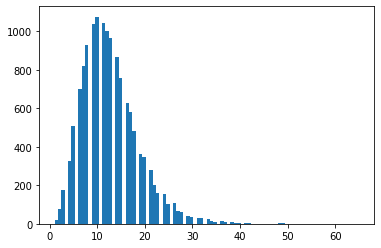

In [33]:
plt.hist(l,bins=90)
plt.show()

In [34]:
len(l[(l>=10) & (l<=20)])

8116

In [35]:
np.random.seed(42)

node_size = 5000

indicies_to_take = np.random.permutation(data_recipe.shape[0])[:node_size]

In [36]:
new_data_recipe = data_recipe.loc[indicies_to_take]

In [37]:
jaccard_similarity_matrix = np.zeros((node_size,node_size))

new_ingredients = new_data_recipe.ingredients.values

for i in tqdm(range(node_size)):
    for j in range(i,node_size):
        jaccard_similarity_matrix[i,j] = 1 - nltk.jaccard_distance(set(new_ingredients[i]), set(new_ingredients[j]))
        jaccard_similarity_matrix[j,i] = jaccard_similarity_matrix[i,j]

100%|██████████| 5000/5000 [01:06<00:00, 75.41it/s] 


In [38]:
np.fill_diagonal(jaccard_similarity_matrix,0)

In [39]:
jaccard_similarity_matrix.min(),jaccard_similarity_matrix.max()

(0.0, 1.0)

In [40]:
np.where(jaccard_similarity_matrix==1)

(array([1035, 1386, 1971, 1979, 2594, 2757, 3577, 4370]),
 array([2757, 3577, 1979, 1971, 4370, 1035, 1386, 2594]))

In [41]:
list(new_data_recipe.title)[1979]

'Minted Simple Syrup '

In [42]:
list(new_data_recipe.title)[1971]

'Rhubarb Mint Coolers '

In [43]:
jaccard_similarity_matrix[1979][1971]

1.0

In [44]:
new_data_recipe[new_data_recipe.title=='Minted Simple Syrup '].ingredients

2012    [mint, sugar, water]
Name: ingredients, dtype: object

In [45]:
new_data_recipe[new_data_recipe.title=='Rhubarb Mint Coolers '].ingredients

6041    [mint, sugar, water]
Name: ingredients, dtype: object

In [46]:
original_data = pd.read_json('data/full_format_recipes.json')

In [47]:
original_data[original_data.title=='Minted Simple Syrup '].iloc[0].ingredients

['1 1/2 cups packed fresh mint leaves', '1 cup sugar', '1 cup water']

In [48]:
original_data[original_data.title=='Rhubarb Mint Coolers '].iloc[0].ingredients

['1 pound trimmed rhubarb',
 '5 cups water',
 '1 cup sugar',
 '1/4 cup packed fresh mint leaves',
 'Garnish: fresh mint sprigs']

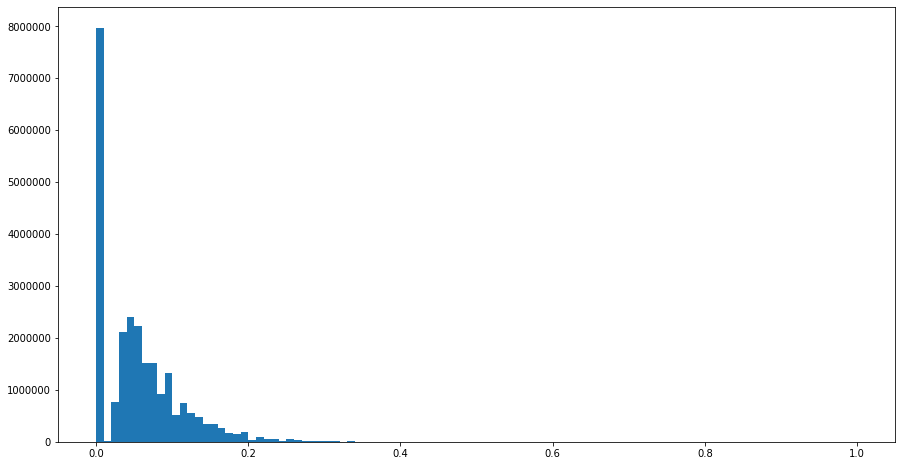

In [49]:
plt.figure(figsize=(15,8))
plt.hist(jaccard_similarity_matrix.flatten(),bins=100)
plt.show()

In [50]:
# np.save('jaccard_similarity_matrix.npy',jaccard_similarity_matrix)

In [51]:
len(jaccard_similarity_matrix[jaccard_similarity_matrix>0])/2

8513497.0

In [57]:
jaccard_similarity_matrix = np.load('jaccard_similarity_matrix.npy')

In [58]:
epsilon = 0.3
jaccard_similarity_matrix[jaccard_similarity_matrix<epsilon] = 0

len(jaccard_similarity_matrix[jaccard_similarity_matrix>0])/2

29952.0

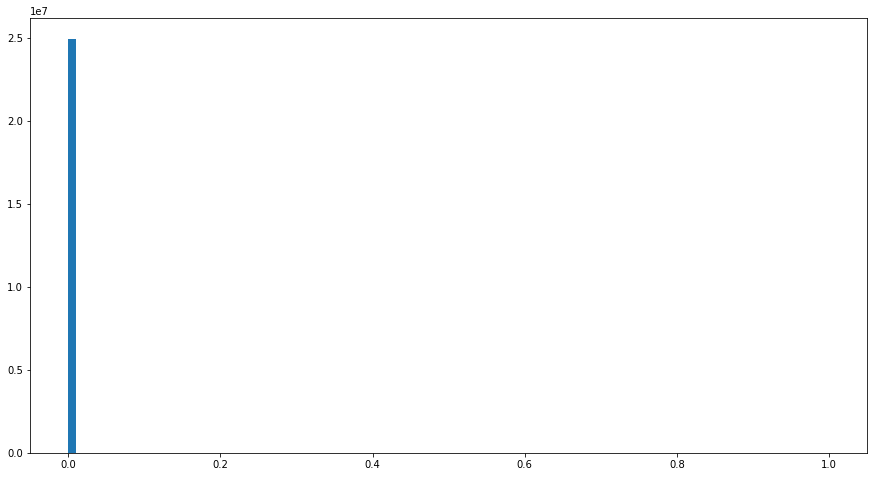

In [59]:
plt.figure(figsize=(15,8))
plt.hist(jaccard_similarity_matrix.flatten(),bins=100)
plt.show()

In [60]:
# np.save('jaccard_similarity_matrix_5000_03.npy',jaccard_similarity_matrix)

In [61]:
import networkx as nx

In [62]:
graph = nx.from_numpy_array(jaccard_similarity_matrix)

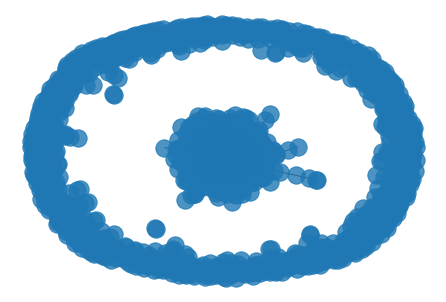

In [65]:
nx.draw_spring(graph, alpha = 0.8)